# CNN

## Convolutional Layerの実装

In [1]:
import time

import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torch import optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import nn

%load_ext autoreload
%autoreload 2
import utils

In [2]:
dataset = torchvision.datasets.MNIST(root='./mnist_data', train=True, download=True)
im, label = dataset[0]
im = transforms.ToTensor()(im)[0, :, :]  # tensor化し、[1,28,28]->[28,28]の2ランクに

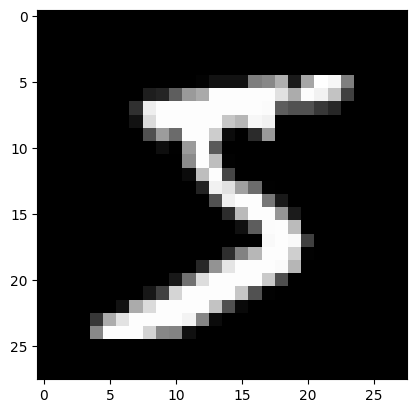

In [3]:
plt.imshow(im, cmap='gray')

In [4]:
im.shape

torch.Size([28, 28])

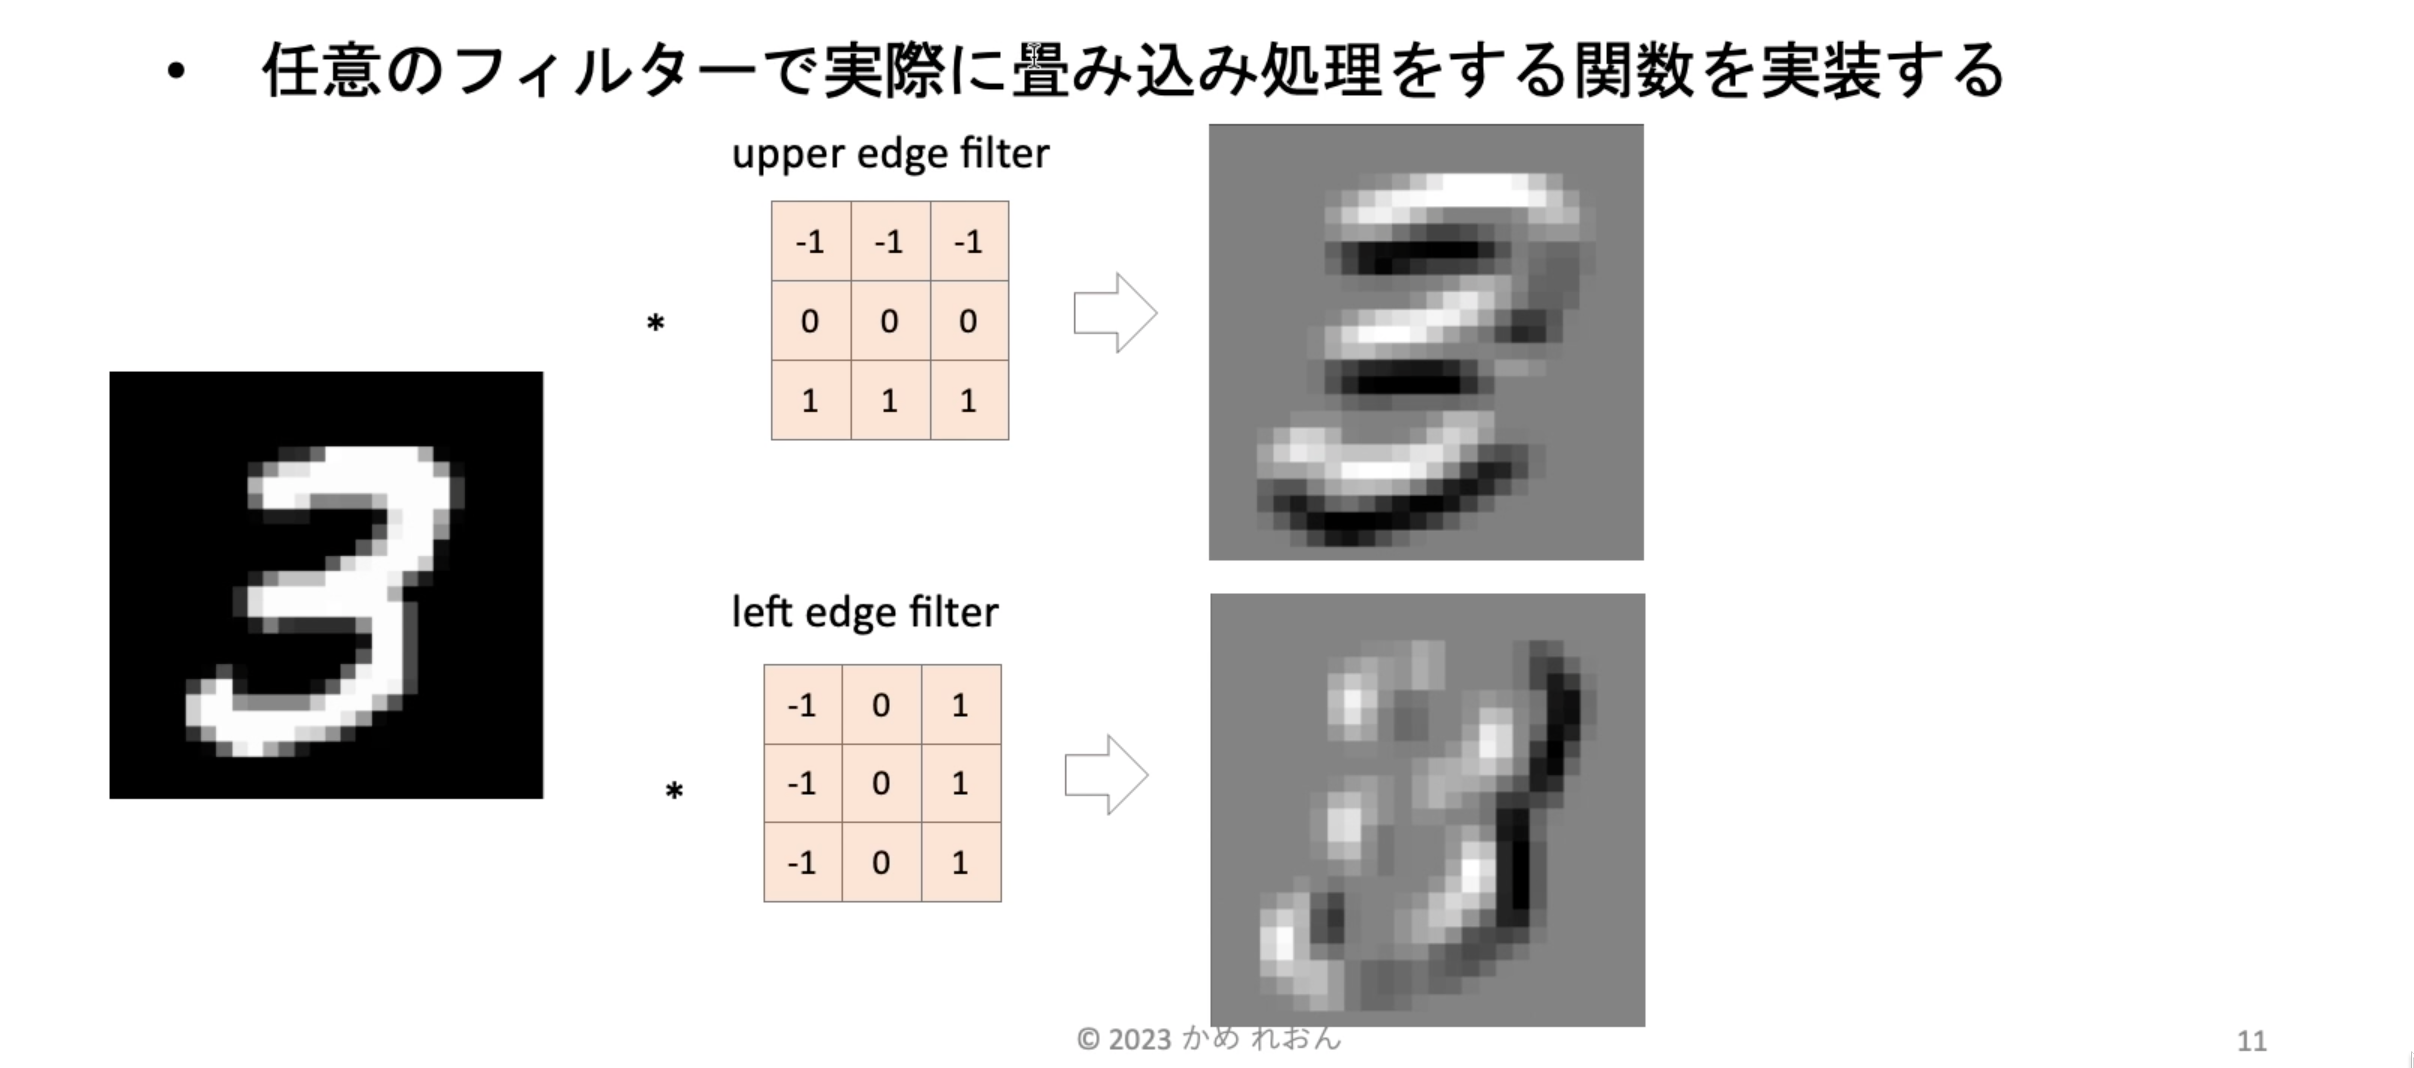

In [5]:
# フィルタ
top_edge_filter = torch.tensor([[-1, -1, -1],
                               [0, 0, 0],
                               [1, 1, 1]])

In [6]:
top_edge_filter

tensor([[-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]])

In [7]:
import pandas as pd
df = pd.DataFrame(im)
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys_r')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.07,0.07,0.07,0.49,0.53,0.69,0.10,0.65,1.00,0.97,0.50,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.14,0.37,0.60,0.67,0.99,0.99,0.99,0.99,0.99,0.88,0.67,0.99,0.95,0.76,0.25,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.93,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.36,0.32,0.32,0.22,0.15,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.86,0.99,0.99,0.99,0.99,0.99,0.78,0.71,0.97,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.61,0.42,0.99,0.99,0.80,0.04,0.00,0.17,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [8]:
im_h, im_w = im.shape
f_h, f_w = top_edge_filter.shape
print(im_h, im_w)  
print(f_h, f_w)

28 28
3 3


In [9]:
def apply_filter(im, filter):  
    im_h, im_w = im.shape
    f_h, f_w = filter.shape
    output_data = []
    for i in range(im_h - f_h + 1):
        row = []
        for j in range(im_w - f_w + 1):
            row.append((im[i:i+f_h, j:j+f_h] * filter).sum().item())
        output_data.append(row)
    return torch.tensor(output_data)

In [10]:
filtered_im = apply_filter(im, top_edge_filter)
filtered_im.shape

torch.Size([26, 26])

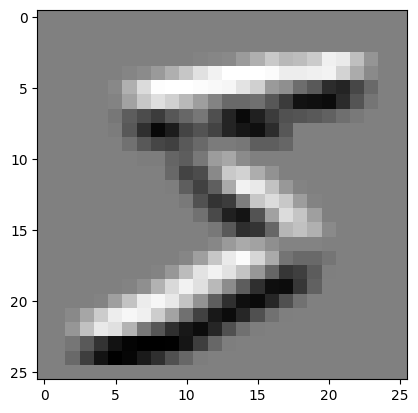

In [11]:
plt.imshow(filtered_im, cmap='gray')

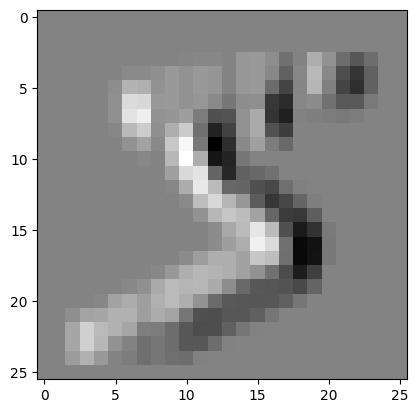

In [12]:
# left edgeフィルタでも同様に畳み込み処理を行う
left_edge_filter = torch.tensor([[-1, 0, 1],
                               [-1, 0, 1],
                               [-1, 0, 1]])
filtered_im = apply_filter(im, left_edge_filter)
plt.imshow(filtered_im, cmap='gray')

## CNN構築

nn.Conv2d
- nn.Linearやnn.ReLU同様に、CNNを畳み込み層のメソッドがnnクラスにある
- nn.Conv2d()でレイヤーのインスタンスを生成
    - 引数を設定
        - in_channels (int): Number of channels in the input image
        - out_channels (int): Number of channels produced by the convolution
        - kernel_size (int or tuple): Size of the convolving kernel
        - stride (int or tuple, optional): Stride of the convolution. Default: 1
        - padding (int, tuple or str, optional): Padding added to all four sides of the input. Default: 0
- 畳み込み層の後にReLU層を挿入する
- 入力サイズ<フィルタサイズの場合、エラーが出るが、パディングを設定することで回避する
- 下記の図を用いてCNNを構築する
- 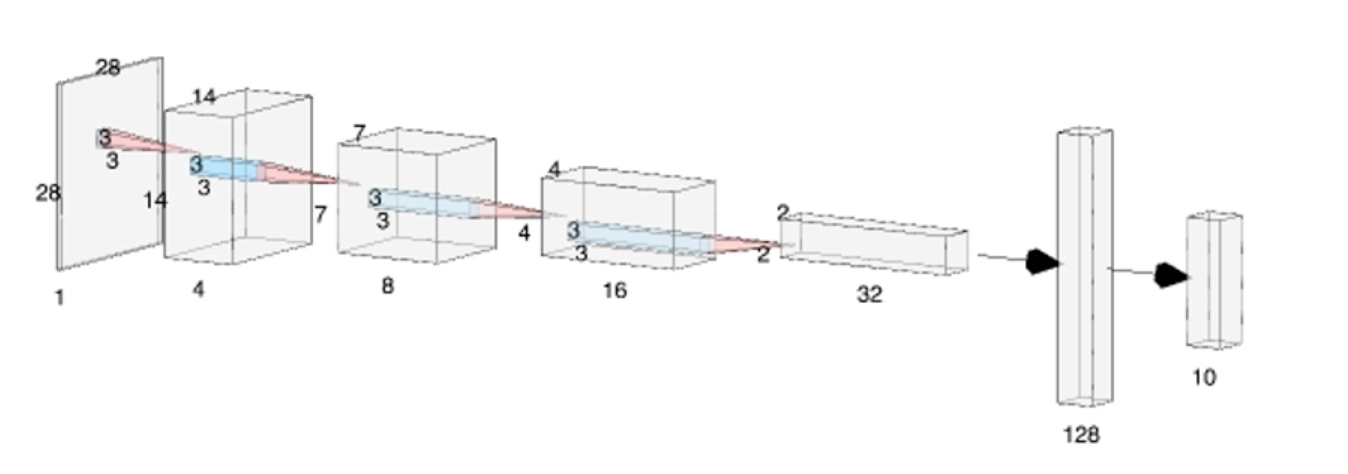

In [13]:
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=2, padding=1), # 1層目は入力1、出力4、画像サイズを半分(28->24)にするのでフィルタ3、ストライド2、パッディング1
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=2, padding=1), 
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1), 
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), 
    nn.ReLU(),
    # 32x2x2
    # nn.Flatten()
    # # 128
    # nn.Linear(128, 10)
    nn.Conv2d(32, 10, kernel_size=3, stride=2, padding=1),  # nn.flatten()->nn.Linear()の形をnn.Conv2d()でもかくことができる
    # 10x1x1
    nn.Flatten()
    # 10
    )

In [14]:
conv_model

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(32, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): Flatten(start_dim=1, end_dim=-1)
)

In [15]:
# サンプルのtensorで順伝播し出力の形状を確認
X = torch.randn((8, 1, 28, 28))
output = conv_model(X)

output.shape

torch.Size([8, 10])

In [16]:
# モデルのパラメータの形状を確認する
# 1層目：3x3のフィルタが4つある、次に続くのはバイアス
for params in conv_model.parameters():
    print(params.shape)
    print('--------------------------------')

torch.Size([4, 1, 3, 3])
--------------------------------
torch.Size([4])
--------------------------------
torch.Size([8, 4, 3, 3])
--------------------------------
torch.Size([8])
--------------------------------
torch.Size([16, 8, 3, 3])
--------------------------------
torch.Size([16])
--------------------------------
torch.Size([32, 16, 3, 3])
--------------------------------
torch.Size([32])
--------------------------------
torch.Size([10, 32, 3, 3])
--------------------------------
torch.Size([10])
--------------------------------


In [17]:
for params in conv_model.parameters():
    print(params)
    print('--------------------------------')

Parameter containing:
tensor([[[[-0.2877, -0.0653, -0.1353],
          [ 0.2282,  0.2662, -0.0413],
          [ 0.2724,  0.3283,  0.0818]]],


        [[[-0.0920, -0.0855,  0.1254],
          [-0.3009, -0.2896, -0.1174],
          [-0.0600,  0.1609, -0.3234]]],


        [[[-0.1296,  0.3141, -0.1360],
          [ 0.2989, -0.1678,  0.2053],
          [-0.2676, -0.1318,  0.0736]]],


        [[[ 0.0528, -0.2466,  0.2618],
          [-0.0192,  0.0331, -0.2327],
          [ 0.0764,  0.1855, -0.1929]]]], requires_grad=True)
--------------------------------
Parameter containing:
tensor([ 0.1796, -0.2806,  0.1398,  0.3252], requires_grad=True)
--------------------------------
Parameter containing:
tensor([[[[-0.0725,  0.0955, -0.0966],
          [ 0.0081,  0.0849,  0.0799],
          [-0.0712,  0.0191, -0.0648]],

         [[ 0.0077,  0.0488, -0.0869],
          [ 0.1016,  0.0121, -0.0597],
          [-0.0968,  0.1513,  0.1203]],

         [[-0.1391, -0.0556, -0.0793],
          [ 0.0499,  0.

In [18]:
# パラメータの総数
# .numel()で要素の数を出力する
# パラメータの総数は9034個
torch.tensor([params.numel() for params in conv_model.parameters()]).sum()

tensor(9034)

In [19]:
# torch.Size([8, 10])なので要素の数は80個
output.numel()

80

## CNN学習

前レクチャーで作成したCNNでMNISTのデータを学習する

In [20]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.MNIST('.mnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST('.mnist_data', train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=4)
X_train, y_train = next(iter(train_loader))

# optimizer
opt = optim.SGD(conv_model.parameters(), lr=0.03)

# 学習
start = time.time()
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, num_epoch=5)
end = time.time()
print(end - start)

epoch: 0: train error: 2.30040048231194, validation error: 2.296542979493926, validation accuracy: 0.11362737341772151


epoch: 1: train error: 2.242714466062436, validation error: 1.7083297469947911, validation accuracy: 0.5462816455696202


epoch: 2: train error: 0.6139883512754176, validation error: 0.3257163989393017, validation accuracy: 0.900118670886076


epoch: 3: train error: 0.2856402323126539, validation error: 0.21901324273476117, validation accuracy: 0.9324564873417721


epoch: 4: train error: 0.20743054318339077, validation error: 0.16808686090656852, validation accuracy: 0.9494659810126582
156.36533427238464


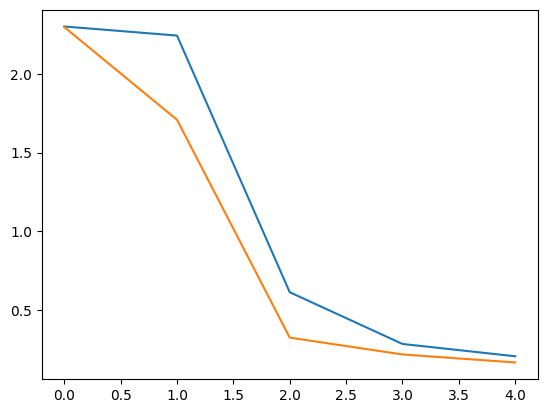

In [21]:
plt.plot(train_losses)
plt.plot(val_losses)

In [22]:
print(X_train.shape, y_train.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [23]:
im, labels = train_dataset[0]
im.shape

torch.Size([1, 28, 28])

In [24]:
y_train

tensor([3, 7, 9, 1, 4, 7, 2, 7, 7, 6, 5, 4, 4, 5, 6, 9, 4, 9, 9, 3, 9, 9, 8, 1,
        3, 2, 0, 6, 7, 7, 3, 1, 4, 5, 1, 6, 0, 3, 9, 7, 2, 9, 9, 1, 0, 1, 2, 1,
        6, 3, 5, 6, 4, 8, 4, 8, 7, 6, 6, 6, 1, 7, 7, 4, 3, 0, 6, 7, 9, 6, 3, 8,
        9, 9, 8, 1, 9, 6, 2, 7, 8, 1, 2, 3, 8, 2, 7, 6, 8, 6, 7, 8, 1, 7, 2, 5,
        6, 1, 7, 2, 8, 1, 4, 9, 3, 5, 2, 7, 0, 0, 6, 4, 7, 8, 7, 9, 1, 2, 0, 0,
        8, 5, 8, 2, 1, 8, 6, 9])

In [25]:
# GPUで処理する場合は以下
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# conv_model.to(device)
opt = optim.SGD(conv_model.parameters(), lr=0.03, )
start = time.time()
# 学習
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, num_epoch=5)
end = time.time()
print(end - start)

epoch: 0: train error: 0.1693024001618438, validation error: 0.14928655329903093, validation accuracy: 0.9544106012658228


epoch: 1: train error: 0.14677119740386252, validation error: 0.1352094848864252, validation accuracy: 0.9591574367088608


epoch: 2: train error: 0.12911286498151864, validation error: 0.11767077461309448, validation accuracy: 0.9649920886075949


epoch: 3: train error: 0.11659991522746554, validation error: 0.10890867562280802, validation accuracy: 0.96875


epoch: 4: train error: 0.10602387747387769, validation error: 0.10485152582213565, validation accuracy: 0.9683544303797469
152.64448046684265
